In [1]:
for p in ("Knet","ArgParse", "Compat", "GZip", "Images","ImageCore")
    Pkg.installed(p) == nothing && Pkg.add(p)
end

In [2]:
using Knet, Compat,GZip,Images, ImageCore

include(Pkg.dir("Knet","data","cifar.jl"))
include(Pkg.dir("Knet","data","imagenet.jl"))


In [77]:
function generate(w,ninstance,o;genfolder="gen/")
    z = samplez(o[:geninputsize],ninstance)
    g = generator(w[1:5],z)
    gz = Array(g)
    gz = (gz+1)/2
    gz = reshape(gz,(32,32,3,ninstance))
    L = floor(Int, sqrt(ninstance))
    for i=1:ninstance
        gz[:,:,:,i] = permutedims(gz[:,:,:,i], (2,1,3))
    end
    images = map(i->gz[:,:,:,i], 1:size(gz,4))
    image = make_image_grid(images; gridsize = (L,L), height = 32, width = 32)
    display(colorview(RGB, image[1,:,:], image[2,:,:], image[3,:,:]))
end

generate (generic function with 1 method)

(3

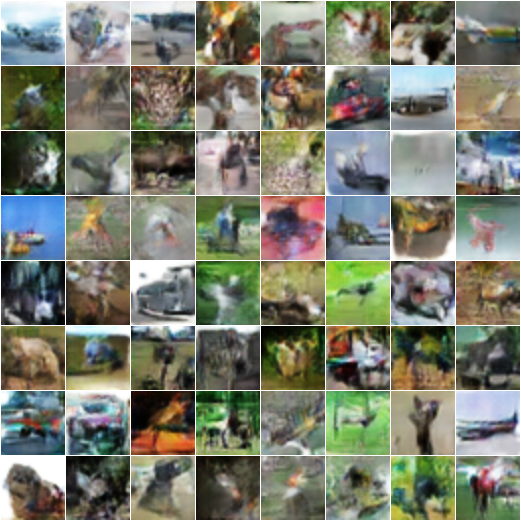

, 521, 521)


In [78]:
generate(w,64,o)

In [4]:
function avgloss(model,data,o)
    b = o[:batchsize]
    geninputsize = o[:geninputsize]
    total=dloss=gloss=0.0
    for (x,_) in data
        for k = 1:o[:k]
            z = samplez(geninputsize,b)
            gz = generator(model[1:5], z)
            dloss += 2*b*discloss(model[6:end],2x-1,gz)
        end
        z = samplez(geninputsize,2*b)
        gloss += 2*b*genloss(model[1:5], model[6:end], z)
        total += 2*b
    end

    return dloss/total,gloss/total
end

avgloss (generic function with 1 method)

In [5]:
function train!(model, data, o,optims)
    b = o[:batchsize]
    geninputsize = o[:geninputsize]
    for i=1:o[:epochs]
        for (x,_) in data
            for k = 1:o[:k]
                z = samplez(geninputsize,b)
                gz = generator(model[1:5], z)
                g = discgradient(model[6:end],2x-1,gz)
                update!(model[6:end], g, optims[6:end])
            end
            z = samplez(geninputsize,2*b)
            g = gengradient(model[1:5], model[6:end], z)
            update!(model[1:5], g, optims[1:5])
        end
        println(avgloss(model,dtrn,o))
    end
    # @save "genparams.jld2" model
    # save("ganparam.jld",model)
end

train! (generic function with 1 method)

In [6]:
function discloss(w,x,gz)
    dx = discriminator(w,x)
    dz = discriminator(w,gz)
    loss = -mean(log.(1e-8 .+ dx)) - mean(log.(1e-8 + 1 .- dz))
    return loss
end
discgradient = grad(discloss)

(::gradfun) (generic function with 1 method)

In [7]:
function genloss(wgen, wdisc, z)
    gz = generator(wgen,z)
    dz = discriminator(wdisc,gz)
    loss = log.(1e-9 .+ dz)
    return -mean(loss)
end
gengradient = grad(genloss)

(::gradfun) (generic function with 1 method)

In [8]:
function leakyrelu(x;alpha = 0.2)
    return max.(0,x) + min.(0,x) * alpha
end

leakyrelu (generic function with 1 method)

In [9]:
function initweightsdisc(; winit=0.02)
    w = Any[]
#     x = ninputs
    
    push!(w, convert(atype, winit*randn(5,5,3,64))) ##neden 2 
    push!(w, convert(atype, zeros(1,1,64,1)))
    push!(w, convert(atype, winit*randn(5,5,64,128)))
    push!(w, convert(atype, zeros(1,1,128,1)))
    push!(w, convert(atype, winit*randn(4,4,128,256)))
    push!(w, convert(atype, zeros(1,1,256,1)))
    push!(w, convert(atype, winit*randn(1, 4096))) 
    push!(w, convert(atype, zeros(1,1)))
    return w
end

initweightsdisc (generic function with 1 method)

In [10]:
function discriminator(w,x)
    
    x =  leakyrelu.(conv4(w[1], x; stride=2,padding=1) .+ w[2])
    x =  leakyrelu.(conv4(w[3], x; stride=2,padding=1) .+ w[4])
    x =  leakyrelu.(conv4(w[5], x; stride=1,padding=0) .+ w[6])   
    return sigm.(w[7]*mat(x) .+ w[8])
end

discriminator (generic function with 1 method)

In [11]:
function initweightsgen(genhidden = 512, geninputsize =100; winit=0.02)
    w = Any[]
    
    push!(w, convert(atype, winit*randn(4096,geninputsize)))
    push!(w, convert(atype, zeros(4096)))
    
    #deconv layers
    push!(w, convert(atype, winit*randn(5,5,128,256))) 
    #push!(w, convert(atype, zeros(1,1,128,1)))
    push!(w, convert(atype, winit*randn(5,5,64,128))) 
    #push!(w, convert(atype, zeros(1,1,64,1)))
    push!(w, convert(atype, winit*randn(4,4,3,64))) 
    #push!(w, convert(atype, zeros(1,1,3,1)))
    
    #last deconv layer
#     push!(w, convert(atype, winit*randn(5,5,3,20))) 
#     push!(w, convert(atype, zeros(1,1,3,1)))
#     println("initgen",length(w))
    return w
end

initweightsgen (generic function with 3 methods)

In [12]:
function generator(w,z)
    x = w[1] * z .+ w[2]
#     @show Array(x1)
#     x2 = leakyrelu.(w[2] * x1)
#     @show Array(x2)
#     println("ingenerator size(x2,2): ", size(x2,2))
    x = reshape(x, 4,4,256,size(x,2))
    x = relu.(deconv4(w[3], x; stride = 1)) #8
#     @show Array(x4)
#     println("ingenerator size(x4): ", size(x4))
    x = relu.(deconv4(w[4], x; stride = 2, padding = 1)) # 17
#     @show Array(x5)
    x = tanh.(deconv4(w[5], x; stride = 2, padding = 2)) #32
#     @show Array(x6)
#   return sigm.(x)#sigm.(deconv4(w[5],x5) .+ w[6])
end

generator (generic function with 1 method)

In [13]:
function samplez(geninputsize, batch)
    convert(atype, randn(Float32, geninputsize, batch))
end

samplez (generic function with 1 method)

In [14]:
xtrn,ytrn,xtst,ytst = cifar10()

INFO: Reading cifar-10-binary.tar.gz...


(Float32[0.231373 0.0627451 … 0.705882 0.694118; 0.168627 0.0 … 0.678431 0.658824; … ; 0.596078 0.466667 … 0.380392 0.592157; 0.580392 0.478431 … 0.32549 0.482353]

Float32[0.243137 0.0784314 … 0.545098 0.564706; 0.180392 0.0 … 0.482353 0.505882; … ; 0.490196 0.32549 … 0.243137 0.462745; 0.486275 0.341176 … 0.207843 0.360784]

Float32[0.247059 0.0784314 … 0.376471 0.454902; 0.176471 0.0 … 0.164706 0.368627; … ; 0.4 0.196078 … 0.133333 0.329412; 0.403922 0.223529 … 0.133333 0.282353]

Float32[0.603922 0.54902 … 0.647059 0.639216; 0.494118 0.568627 … 0.611765 0.619608; … ; 0.341176 0.301961 … 0.482353 0.560784; 0.309804 0.278431 … 0.513726 0.560784]

Float32[0.694118 0.627451 … 0.603922 0.580392; 0.537255 0.6 … 0.596078 0.580392; … ; 0.352941 0.313726 … 0.447059 0.52549; 0.317647 0.286275 … 0.47451 0.521569]

Float32[0.733333 0.662745 … 0.501961 0.470588; 0.533333 0.603922 … 0.509804 0.478431; … ; 0.278431 0.243137 … 0.470588 0.556863; 0.27451 0.239216 … 0.513726 0.564706]

Float32[1.0 1

In [15]:
function main(o)
#     s = ArgParseSettings()
#     s.description="Generative Adversarial Networks Knet Implementation."
#     s.exc_handler=ArgParse.debug_handler
#     @add_arg_table s begin
#         ("--seed"; arg_type=Int; default=-1; help="random number seed: use a nonnegative int for repeatable results")
#         ("--batchsize"; arg_type=Int; default=32; help="minibatch size")
#         ("--lr"; arg_type=Float64; default=0.2; help="learning rate")
#         ("--k"; arg_type=Int; default=1; help="k")
#         ("--geninputsize"; arg_type=Int; default=784; help="size of the generator's input")
#         ("--genhidden"; arg_type=Int; default=512; help="sizes of the generator hidden layer")
#         ("--dischidden"; arg_type=Int; default=256; help="sizes of the discriminator hidden layer")
#         ("--fast"; action=:store_true; help="skip loss printing for faster run")
#         ("--epochs"; arg_type=Int; default=3; help="number of epochs for training")
#         ("--iters"; arg_type=Int; default=typemax(Int); help="maximum number of updates for training")
#         ("--gcheck"; arg_type=Int; default=0; help="check N random gradients per parameter")
#         ("--atype"; default=(gpu()>=0 ? "KnetArray{Float32}" : "Array{Float32}"); help="array and float type to use")
#     end
#     isa(args, AbstractString) && (args=split(args))
#     if in("--help", args) || in("-h", args)
#         ArgParse.show_help(s; exit_when_done=false)
#         return
#     end
#     println(s.description)
#     o = parse_args(args, s; as_symbols=true)
    println("o=",[(k,v) for (k,v) in o]...)
    o[:seed] > 0 && srand(o[:seed])
    global atype = eval(parse(o[:atype]))
    # if atype <: Array; warn("CPU conv4 support is experimental and very slow."); end

    global dtrn = minibatch(xtrn, ytrn, o[:batchsize]; xtype=atype)
    global dtst = minibatch(xtst, ytst, o[:batchsize]; xtype=atype)
    
    imsize = 32*32*3

    w = initweightsgen(o[:genhidden], o[:geninputsize])
    discw = initweightsdisc()
    append!(w, discw)
    optims = map(wi->eval(parse(o[:optim])), w)
    return w,o,optims,dtrn,dtst
    
    println("happiness")
    println(avgloss(w,dtst,o))
    generate(w,2,o)
    global prew = Array(w[5])
    train!(w, dtrn, o, optims)
    println(avgloss(w,dtst,o))
    generate(w,10,o)

    return w,o,optims,dtrn,dtst
end

main (generic function with 1 method)

In [ ]:
display(colorview(RGB, xtrn[:,:,1,1],xtrn[:,:,2,1],xtrn[:,:,3,1]))

Array(w[5])

In [ ]:
generator(modeltrn, samplez(100, 1))

In [16]:
arrtype = gpu()>=0 ? "KnetArray{Float32}" : "Array{Float32}";
args = Dict(:seed=>-1,:batchsize=>32,:lr=>0.02,:k=>1,:geninputsize=>100,:optim=>"Adam(lr=0.0001,beta1=0.5)", :genhidden=>512, :dischidden=>256, :epochs=>1,:gcheck=>0,:atype=>arrtype);
w,o,optims,dtrn,dtst= main(args)

o=(:geninputsize, 100)(:atype, "KnetArray{Float32}")(:genhidden, 512)(:batchsize, 32)(:k, 1)(:dischidden, 256)(:epochs, 1)(:gcheck, 0)(:optim, "Adam(lr=0.0001,beta1=0.5)")(:lr, 0.02)(:seed, -1)


(Any[Knet.KnetArray{Float32,2}(Knet.KnetPtr(Ptr{Void} @0x00000012051c0000, 1638400, 0, nothing), (4096, 100)), Knet.KnetArray{Float32,1}(Knet.KnetPtr(Ptr{Void} @0x0000001204fc0000, 16384, 0, nothing), (4096,)), Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x0000001205360000, 3276800, 0, nothing), (5, 5, 128, 256)), Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x0000001205680000, 819200, 0, nothing), (5, 5, 64, 128)), Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x0000001204fc4000, 12288, 0, nothing), (4, 4, 3, 64)), Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x0000001205780000, 19200, 0, nothing), (5, 5, 3, 64)), Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x0000001205880000, 256, 0, nothing), (1, 1, 64, 1)), Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x0000001205980000, 819200, 0, nothing), (5, 5, 64, 128)), Knet.KnetArray{Float32,4}(Knet.KnetPtr(Ptr{Void} @0x0000001205880200, 512, 0, nothing), (1, 1, 128, 1)), Knet.KnetArray{Float32,4}(Knet.KnetPtr(

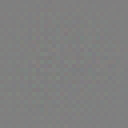

optims[1] = Knet.Adam(0.0001, 0.0, 0.5, 0.999, 1.0e-8, 0, nothing, nothing)


32×32×3×1 Array{Float32,4}:
[:, :, 1, 1] =
 0.499943  0.501718  0.499081  0.498371  …  0.502233  0.500843  0.500881
 0.497851  0.497363  0.495597  0.500552     0.503552  0.498828  0.500857
 0.500921  0.498677  0.496129  0.501177     0.498745  0.497131  0.500285
 0.500538  0.505515  0.501688  0.503218     0.496102  0.503897  0.50028 
 0.506776  0.504705  0.49713   0.495665     0.50493   0.49943   0.498635
 0.496783  0.500787  0.500175  0.498025  …  0.493408  0.49825   0.495209
 0.49814   0.499921  0.502636  0.503379     0.502914  0.492168  0.49874 
 0.500488  0.499394  0.501049  0.502618     0.497944  0.494742  0.501136
 0.499552  0.509508  0.494759  0.494985     0.503651  0.500739  0.496434
 0.503685  0.497801  0.503375  0.491235     0.500858  0.497934  0.501882
 0.499531  0.501007  0.501135  0.499892  …  0.506598  0.491428  0.490941
 0.501051  0.503457  0.49498   0.496199     0.501729  0.503031  0.499509
 0.49833   0.502272  0.499289  0.501204     0.509309  0.499981  0.504927
 ⋮      

In [17]:
@show optims[1]
z = Array(generator(w, samplez(100, 1)))
z = (z+1)/2
display(colorview(RGB, z[:,:,1,1],z[:,:,2,1],z[:,:,3,1]))
z

In [157]:
 println(avgloss(w,dtst,o))

(1.3836566190689037, 0.6933100005755057)


In [18]:
for i=1:10
     train!(w, dtrn, o, optims)
end

(1.225945609250844, 0.8916012333770414)
(0.9131457453805872, 1.3751862887078454)
(1.3654997825775195, 0.8072035131396466)
(1.036793092873887, 1.3332255176636993)
(1.160399763135385, 0.8599604679207186)
(0.9846938647014994, 1.022413277748147)
(1.1609468785962436, 0.9066598583275164)
(1.212974999610349, 0.8267566699071974)
(1.2619487387575352, 0.8000720578332869)
(1.2667367759801056, 0.8397909705068024)


In [23]:
w1 = deepcopy(w)
for i=1:10
     train!(w, dtrn, o, optims)
end
#20 epochs

(1.2528478752025112, 0.7722651257099782)
(1.2924245587536987, 0.8956350325851221)
(1.2629042241851132, 0.8408724945730193)
(1.2646781886127634, 0.8306186633821333)
(1.2269157687924737, 0.8451568658312213)
(1.2848656484320589, 0.8387662089130484)
(1.2618104623160808, 0.8367091089906827)
(1.339692925445249, 0.8504813510385579)
(1.25641117099, 0.8680032397430777)
(1.276658720991523, 0.784470980321552)


In [25]:
w2 = deepcopy(w)
for i=1:10
     train!(w, dtrn, o, optims)
end
#30 epochs

(1.310221226358841, 0.7782380644246344)
(1.2672013567138114, 0.8574623887960188)
(1.272794067325421, 0.902611592171592)
(1.2635321267588344, 0.8902110578384961)
(1.1987645991251503, 0.9357123859179005)
(1.193720349696168, 0.9132208277336614)
(1.2259773837161583, 0.8681717832476168)
(1.2020570422104164, 0.8888680580788783)
(1.1862215192919352, 0.8561547695445648)
(1.2461549640465026, 0.8161554966937564)


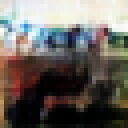

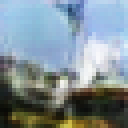

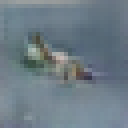

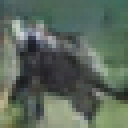

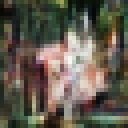

In [39]:
generate(w,5,o)

In [37]:
w3 = deepcopy(w)
for i=1:10
     train!(w, dtrn, o, optims)
end
#40 epochs

(1.2405036620309198, 0.8934301495857336)
(1.226043181138521, 0.8011589218193377)
(1.209190057769475, 0.9421815810756097)
(1.2164396322719877, 0.9333125250211293)
(1.2089923267633143, 1.0400924550968005)
(1.1864298396241801, 1.0743588633100751)
(1.1319192092717838, 1.0549635332311467)
(1.164919316959442, 0.8484129964084235)
(1.1852311449227961, 1.017203040182514)
(1.1600420259406716, 1.0066924479416788)


In [79]:
w4 = deepcopy(w)
for i=1:10
     train!(w, dtrn, o, optims)
end
#50 epochs

(1.1151930551675462, 0.9792248850900599)
(1.1222799384105526, 1.055644803865313)
(1.124347061987265, 1.104222237376947)
(1.0704251742240867, 1.0774193437777164)
(1.0465493449862575, 1.0402065543374392)
(1.0942981277095218, 1.126139139205637)
(1.020000323939415, 1.095284052603376)
(1.0517997668433585, 1.1731617955941702)
(1.0366066269929521, 1.1430718495430623)
(NaN, NaN)


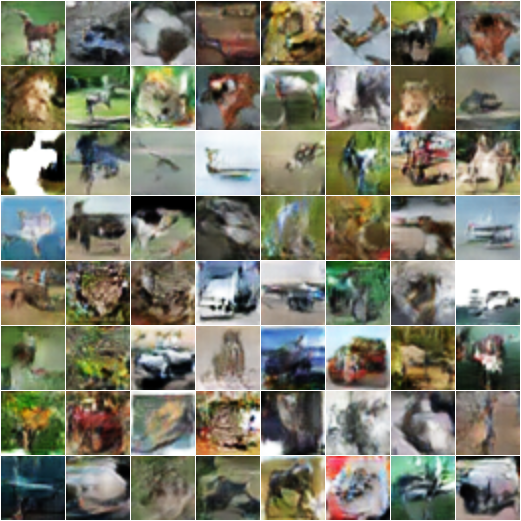

(3, 521, 521)


In [81]:
generate(w4,64,o)

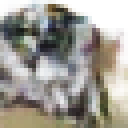

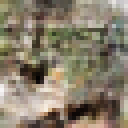

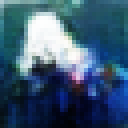

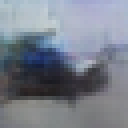

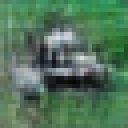

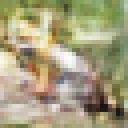

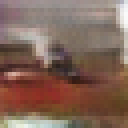

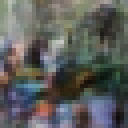

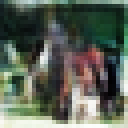

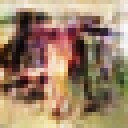

In [30]:
generate(w,10,o)

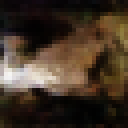

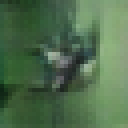

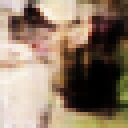

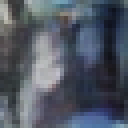

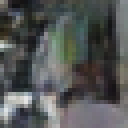

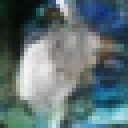

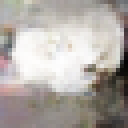

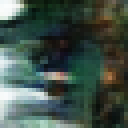

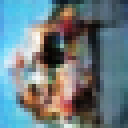

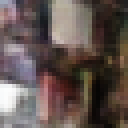

In [27]:
generate(w, 10,o)

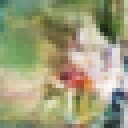

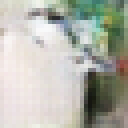

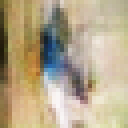

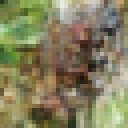

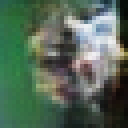

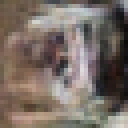

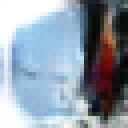

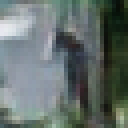

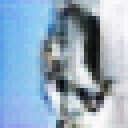

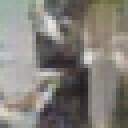

In [24]:
generate(w, 10,o)

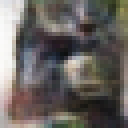

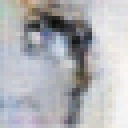

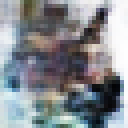

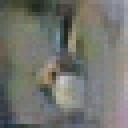

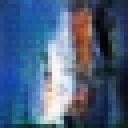

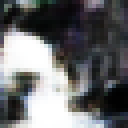

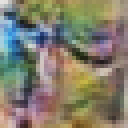

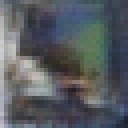

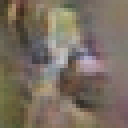

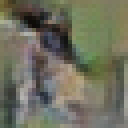

In [21]:
generate(w, 10,o)